In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data = pd.read_csv('/content/drive/My Drive/fer2013.csv')

In [4]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
data.shape

(35887, 3)

In [6]:
labels = data.iloc[:, 0]

In [7]:
pixels = data.iloc[:, 1]
images = np.zeros((pixels.shape[0], 48*48))
for ix in range(images.shape[0]):
    p = pixels[ix].split(' ')
    for iy in range(images.shape[1]):
        images[ix, iy] = int(p[iy])

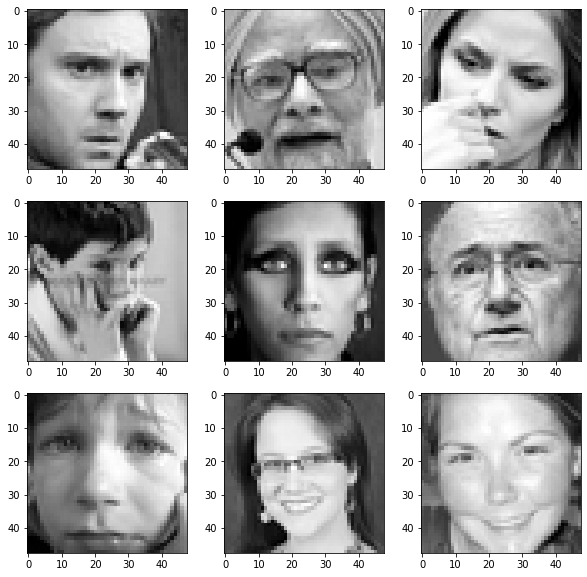

In [8]:
plt.figure(figsize = (10,10))
for index,image in enumerate(images[:9]):
    plt.subplot(3,3,index+1)
    plt.imshow(image.reshape((48,48)), cmap = 'gray')
plt.show()

In [9]:
train_or_test = data.iloc[:, 2].values
data["Usage"].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [10]:
data['emotion'].unique()

array([0, 2, 4, 6, 3, 5, 1])

In [31]:
reshaped_images = np.zeros((images.shape[0], 48, 48,1))
i = 0
for image in images:
  reshaped_images[i] = image.reshape((48,48,1))
  i+=1

In [32]:
reshaped_images.shape

(35887, 48, 48, 1)

In [52]:
norm_images = reshaped_images / 255.0

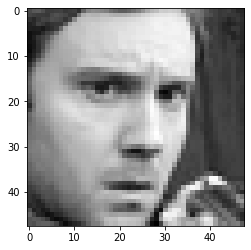

In [53]:
plt.imshow(norm_images[0].reshape((48,48)), cmap="gray")
plt.show()

In [14]:
from tensorflow.keras.utils import to_categorical

In [15]:
new_labels = to_categorical(labels, num_classes=7)
new_labels.shape

(35887, 7)

In [34]:
reshaped_images.shape

(35887, 48, 48, 1)

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(norm_images, new_labels, test_size=0.2, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((28709, 48, 48, 1), (7178, 48, 48, 1), (28709, 7), (7178, 7))

In [92]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [20]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [55]:
model = Sequential()

model.add(Conv2D(64, (3,3), padding = "same", input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (5,5), padding = "same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3,3), padding = "same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3,3), padding = "same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation = "softmax"))

In [56]:
opt = Adam(lr = 0.0005)

model.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ['accuracy'])

In [57]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_24 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
activation_24 (Activation)   (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_25 (Batc (None, 24, 24, 128)      

In [58]:
epochs = 50

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')

checkpoint = ModelCheckpoint("fer_model.h5", monitor='val_loss', 
                             mode='max', verbose=1)

callbacks = [checkpoint, reduce_lr]

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks=callbacks, epochs = epochs)

Epoch 1/50
898/898 [==============================] - ETA: 0s - loss: 1.7589 - accuracy: 0.3236
Epoch 00001: saving model to fer_model.h5
898/898 [==============================] - 16s 18ms/step - loss: 1.7589 - accuracy: 0.3236 - val_loss: 1.5321 - val_accuracy: 0.4047
Epoch 2/50
897/898 [============================>.] - ETA: 0s - loss: 1.4281 - accuracy: 0.4478
Epoch 00002: saving model to fer_model.h5
898/898 [==============================] - 16s 18ms/step - loss: 1.4280 - accuracy: 0.4479 - val_loss: 1.6897 - val_accuracy: 0.4132
Epoch 3/50
897/898 [============================>.] - ETA: 0s - loss: 1.2878 - accuracy: 0.5072
Epoch 00003: saving model to fer_model.h5
898/898 [==============================] - 16s 18ms/step - loss: 1.2881 - accuracy: 0.5072 - val_loss: 1.4960 - val_accuracy: 0.4142
Epoch 4/50
895/898 [============================>.] - ETA: 0s - loss: 1.2069 - accuracy: 0.5418
Epoch 00004: saving model to fer_model.h5
898/898 [==============================] - 16s 18

In [59]:
emotions = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')

In [60]:
import PIL
from PIL import Image

In [62]:
import cv2

In [80]:
img = cv2.imread("/content/angry-1.jpg")

In [81]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [82]:
img.shape

(259, 194)

In [83]:
img = cv2.resize(img, (48,48))

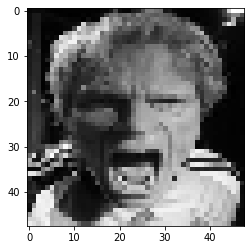

In [84]:
plt.imshow(img, cmap='gray')

In [86]:
np.argmax(model.predict(img.reshape((1,48,48,1))), axis=-1)[0]

0

In [87]:
model.save("Fer_Model.h5")

In [88]:
model.save_weights("model_weights.h5")

In [89]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)